# Exploring Dandiset 000617: Allen Institute Openscope - Sequence Learning Project

> **Note**: This notebook was generated with AI assistance. Users should carefully validate all code and results.

## Overview
This Dandiset contains two-photon calcium imaging data from the Allen Institute's Sequence Learning Project, investigating predictive computations in mouse visual cortex. Mice viewed repeating sequences of natural movie clips while neural activity was recorded using GCaMP6f calcium imaging across multiple visual cortical areas.

**Link to Dandiset**: [DANDI:000617](https://dandiarchive.org/dandiset/000617/0.250312.0130)

This notebook covers:
- Loading and navigating NWB files from the Dandiset
- Exploring calcium imaging data (ΔF/F traces)
- Examining stimulus presentation structure
- Accessing behavioral measurements

## Required Packages
```python
dandi
pynwb
h5py
remfile
numpy
matplotlib
pandas
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dandi.dandiapi import DandiAPIClient
import pynwb
import h5py
import remfile

## Loading Data from DANDI
First, we'll establish connection to DANDI and access a representative NWB file:

In [2]:
# Initialize DANDI API client
dandiset_id = "000617"
dandiset_version = "0.250312.0130"
client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# List example NWB files (first 10)
assets = dandiset.get_assets_by_glob("*.nwb")
print("Example NWB files in DANDI:000617 (first 10):\n")
for i, asset in enumerate(list(assets)[:10]):
    size_mb = asset.size / 1e6
    print(f"{i+1}. {asset.path} ({size_mb:.1f} MB)")

Example NWB files in DANDI:000617 (first 10):



1. sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb (21166.3 MB)
2. sub-684475/sub-684475_ses-1294084428-acq-1294179943-raw-movies_ophys.nwb (21161.4 MB)
3. sub-684475/sub-684475_ses-1293785946-acq-1293914859-raw-movies_ophys.nwb (21174.8 MB)
4. sub-684475/sub-684475_ses-1294084428-acq-1294179942-raw-movies_ophys.nwb (21157.7 MB)
5. sub-684475/sub-684475_ses-1294259213-acq-1294370666-raw-movies_ophys.nwb (21179.6 MB)
6. sub-684475/sub-684475_ses-1294259213-acq-1294370664-raw-movies_ophys.nwb (21178.5 MB)
7. sub-684475/sub-684475_ses-1293785946-acq-1293914856-raw-movies_ophys.nwb (21203.0 MB)
8. sub-684475/sub-684475_ses-1294259213-acq-1294370663-raw-movies_ophys.nwb (21155.1 MB)
9. sub-684475/sub-684475_ses-1293785946-acq-1293914853-raw-movies_ophys.nwb (21160.0 MB)
10. sub-684475/sub-684475_ses-1293785946-acq-1293914860-raw-movies_ophys.nwb (21187.1 MB)


## Examining an Example NWB File
We'll load one NWB file to explore its structure and contents:

In [3]:
# Load a specific NWB file
asset_path = "sub-684475/sub-684475_ses-1294084428-acq-1294179945-raw-movies_ophys.nwb"
asset = next(dandiset.get_assets_by_glob(asset_path))
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## Exploring Cell Segmentation Data
The dataset contains information about segmented cells (ROIs) and their properties:

In [4]:
# Get cell segmentation table
table = nwb.processing['ophys'].data_interfaces['image_segmentation'].plane_segmentations['cell_specimen_table']
cells_df = table.to_dataframe()

# Print summary information
print(f"Number of segmented ROIs: {len(cells_df)}\n")
print("Columns in segmentation table:")
for col in cells_df.columns:
    print(f"- {col}")

# Get imaging plane info
im_plane = table.imaging_plane
print("\nImaging plane information:")
print(f"Location: {im_plane.location}")
print(f"Description: {im_plane.description}")
print(f"Indicator: {im_plane.indicator}")
print(f"Imaging Rate: {im_plane.imaging_rate} Hz")
print(f"Excitation Wavelength: {im_plane.excitation_lambda} nm")

Number of segmented ROIs: 18

Columns in segmentation table:
- cell_specimen_id
- height
- mask_image_plane
- max_correction_down
- max_correction_left
- max_correction_right
- max_correction_up
- valid_roi
- width
- x
- y
- image_mask

Imaging plane information:
Location: VISpm
Description: (512, 512) field of view in VISpm at depth 271 um
Indicator: GCaMP6f
Imaging Rate: 10.0 Hz
Excitation Wavelength: 910.0 nm


## Visualizing Neural Activity
Let's examine the calcium imaging data (ΔF/F) for several cells:

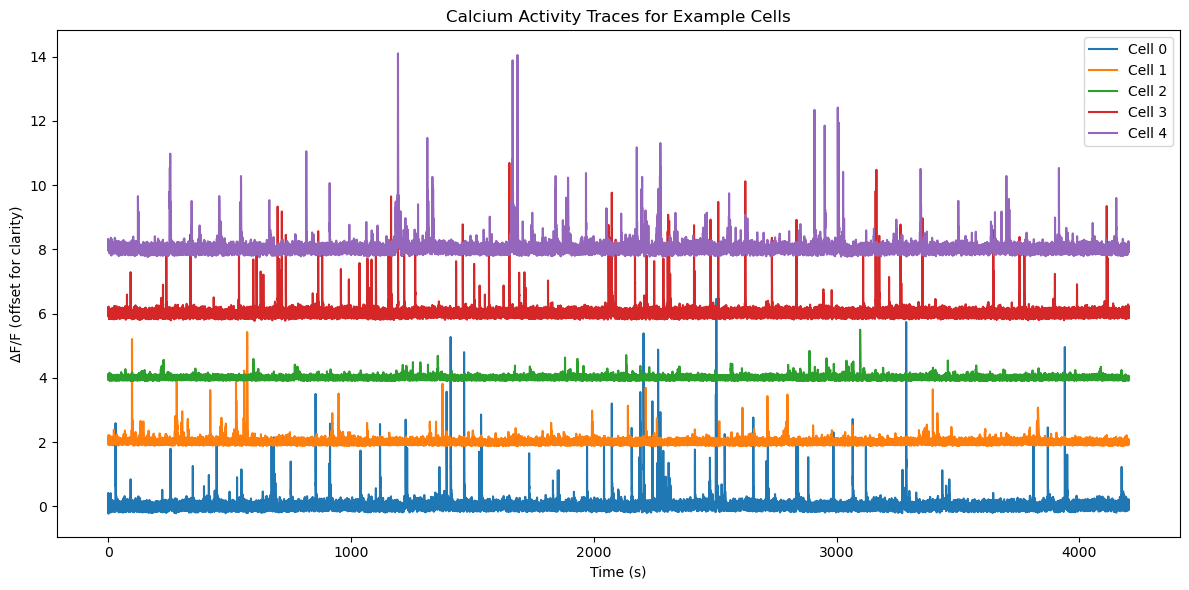

In [5]:
# Extract dF/F traces and timestamps
dff = nwb.processing['ophys'].data_interfaces['dff'].roi_response_series['traces']
dff_data = dff.data[:, :].T  # shape: n_cells x n_timepoints
stamps = dff.timestamps[:]
t = stamps - stamps[0]  # start from 0

# Plot traces for first 5 cells
n_plot = min(5, dff_data.shape[0])
plt.figure(figsize=(12, 6))
offset = 2  # vertical offset between traces
for i in range(n_plot):
    plt.plot(t, dff_data[i] + i*offset, label=f'Cell {i}')
plt.xlabel('Time (s)')
plt.ylabel('ΔF/F (offset for clarity)')
plt.title('Calcium Activity Traces for Example Cells')
plt.legend()
plt.tight_layout()
plt.show()

## Stimulus Presentation Structure
The experiment included presentations of different movie clips and gray screens:

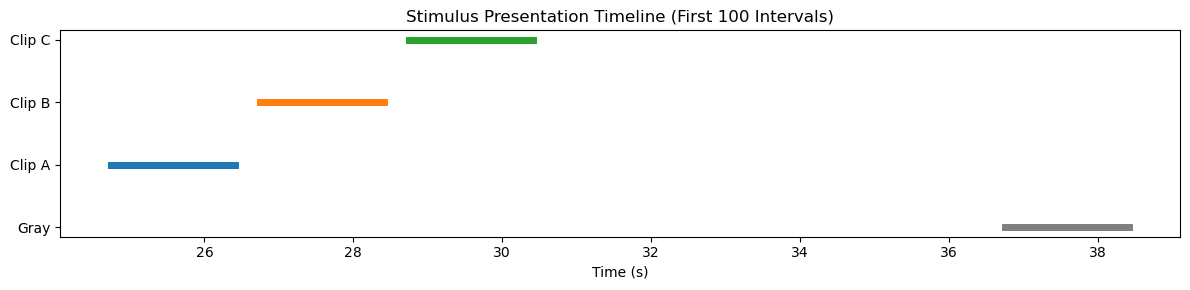


Total presentation counts:
gray_presentations: 63000
movie_clip_A_presentations: 63000
movie_clip_B_presentations: 63000
movie_clip_C_presentations: 63000


In [6]:
# Get presentation counts for each stimulus type
stim_names = ['gray_presentations', 'movie_clip_A_presentations', 
              'movie_clip_B_presentations', 'movie_clip_C_presentations']

# Plot first 100 stimulus intervals
colors = ['gray', 'tab:blue', 'tab:orange', 'tab:green']
fig, ax = plt.subplots(figsize=(12, 3))
yoff = 0
for stim_name, color in zip(stim_names, colors):
    tbl = nwb.intervals[stim_name]
    n_plot = min(len(tbl), 100)
    starts = tbl['start_time'].data[:n_plot]
    stops = tbl['stop_time'].data[:n_plot]
    for s, e in zip(starts, stops):
        ax.plot([s, e], [yoff, yoff], color=color, lw=5)
    yoff += 1
ax.set_yticks(range(len(stim_names)))
ax.set_yticklabels(['Gray', 'Clip A', 'Clip B', 'Clip C'])
ax.set_xlabel('Time (s)')
ax.set_title('Stimulus Presentation Timeline (First 100 Intervals)')
plt.tight_layout()
plt.show()

# Print total presentation counts
print('\nTotal presentation counts:')
for name in stim_names:
    print(f"{name}: {len(nwb.intervals[name])}")

## Behavioral Data
The dataset includes running speed measurements synchronized with neural recordings:

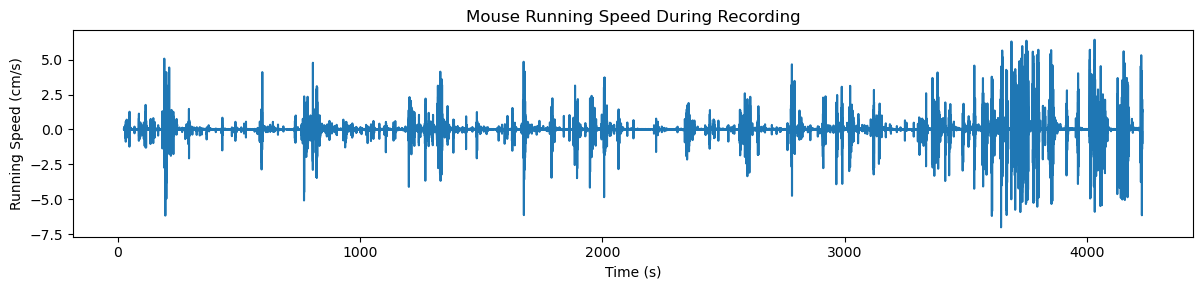

In [7]:
# Get running speed data
speed = nwb.processing['running'].data_interfaces['speed']
run_time = speed.timestamps[:]
speed_data = speed.data[:]

# Plot running speed
plt.figure(figsize=(12, 3))
plt.plot(run_time, speed_data)
plt.xlabel('Time (s)')
plt.ylabel('Running Speed (cm/s)')
plt.title('Mouse Running Speed During Recording')
plt.tight_layout()
plt.show()

## Next Steps
This dataset enables various analyses:
- Trial-aligned neural responses to movie clips
- Comparison of responses across visual areas
- Relationship between running behavior and neural activity
- Population-level sequence learning effects

The NWB files contain additional data not covered here, including:
- Eye tracking measurements
- Event detection results
- Motion correction parameters
- Multiple imaging planes per session